# EGL-19 Parameter Fitting

### Setup & Data Import

In [206]:
import csv
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import random
import operator
import statistics
import time
from IPython import display

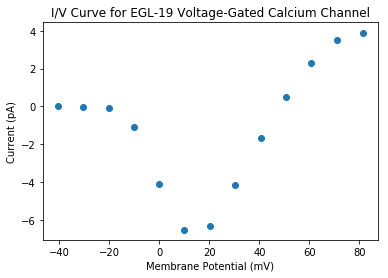

In [207]:
# Import patch clamp data for ion channel
with open('../data/EGL-19_patch_clamp.csv', 'r') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    patch_clamp_data = np.array(list(reader))
    
# Use x-coordinates to evaluate candidate functions later
data_range = patch_clamp_data[:,:1]

# Plot IV curve for patch clamp experiment
x, y = patch_clamp_data.T
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Current (pA)')
plt.title('I/V Curve for EGL-19 Voltage-Gated Calcium Channel')
plt.scatter(x,y)

### Simulation Helper Functions

In [208]:
# Define Hodgkin-Huxley ion channel model
# Put a cutoff on the argument to the exponential
def i(gmax, Vhalf, k, Vrev, V): 
    diffR = V - Vrev
    diffH = Vhalf - V
    num = float(gmax)
    denom = 1 + math.exp(min(diffH/k, 700))
    return (num / denom)*diffR

# Generate candidate solutions
# Ranges: 
# Gmax- [0, 1]
# Vhalf- [0, 1]
# k- [0, 5]
# Vrev- [0, 70]

# Constants
pop_size = 100
twin = 1000
ru = random.uniform

def create_first_gen(n):
    return [[ru(0,1), ru(0,1), ru(0,5), ru(0,70)] for x in range(n)]

def cost_func(m1, m2):
    return np.linalg.norm(np.array(m1)-np.array(m2), ord=2)

def calculate_norm(params, time_series):
    global append_values
    data_range = patch_clamp_data[:,:1]
    data_values = [x[1] for x in patch_clamp_data]
    append_values = [np.insert(params, 4, x, axis=0) for x in data_range]
    test_values = [i(x[0], x[1], x[2], x[3], x[4]) for x in append_values]
    return cost_func(test_values, data_values)

def generate_parameter_space(p_gen, time_series):
    all_norms = [[x, calculate_norm(x, time_series)] for x in p_gen]
    sorted_norms = all_norms.sort(key=operator.itemgetter(1))
    best_candidate = sorted_norms[0][0]
    return [random_gaussian_drift(best_candidate) for x in range(pop_size)]

### Mutation Operators

In [209]:
"""
Mutations operators:
1) Random mutation over the parameter space
2) Random Guassian drift centered around current value with 5% variance
"""

def random_mutation(x, n):
    choices = {0: ru(0,1), 1: ru(0,1), 2: ru(0,5), 3: ru(0,70)}
    return choices[n]

def random_gaussian_drift(x):
    return np.random.normal(x, .05*x)

def mutate(x, n):
    bool = ru(0,1) < .01
    if bool:
        if bool(random.getrandbits(1)):
            return random_mutation(x,n)
        else: 
            return random_gaussian_drift(x)
    else: 
        return x

def one_point_swap(list1, list2, n):
    temp = list1[n]
    list1[n] = list2[n]
    list2[n] = temp
    return list1, list2

def random_crossover(list1, list2):
    return one_point_swap(list1, list2, random.randint(0,3))

def check_threshold(sim_hist):
    if len(sim_hist) < 2:
        return 1
    else:
        return statistics.variance(sim_hist[-twin:])

### Display Functions

In [219]:
def make_grid(current_round, norm_values):
    print("Current Round: ", current_round)
    plt.xlabel('Number of Generations')
    plt.ylabel('Fitness of Best Solution')
    plt.title('Simulation History')
    plt.scatter(range(1,len(norm_values)+1), norm_values)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    
def display_results(sim_norms):
    return 0

### Core Simulation Functions

In [215]:
def ion_channel_fit(time_series):
    global running_tally
    global num_rounds
    global start_AS
    global living
    global norms
    global all_orgs
    global total_solutions
    global running_tally
    global new_parameter_space
    global temp
    num_rounds  = 0
    start_AS = 1000
    living = []
    norms = []
    all_orgs = []
    total_solutions = 0
    running_tally = []
    
    while(check_threshold(running_tally) > 10^-5):
        num_rounds = num_rounds + 1
        
        """
            1) Set the parameter space / "organisms" for the current round.
            2) Reset the list $living{} so that the current surviving organisms will be added to it.
            3) Calculate all the norms of the current set.  Sort, and retain the highest scoring individual.
            4) New addition: Adaptive sampling
        """
        
        if num_rounds == 1:
            new_parameter_space = create_first_gen(100)
        
        elif 2 <= num_rounds <= start_AS:
            new_parameter_space = living
        
        else:
            new_parameter_space = generate_parameter_space(living, time_series)
        
        """
        This next section simply ensures that the highest scoring individual
        is always retained in each round.  
        """
        round_length = round(len(new_parameter_space) / 2)
        living = []
        temp = [[x, calculate_norm(x, time_series)] for x in new_parameter_space]
        temp.sort(key=operator.itemgetter(1))
        norms = temp
        living.append(norms[0][0])
        all_orgs.append(norms[0][0])
        running_tally.append(norms[0][1])

        """
        Begin inner loop:
        This is the tournament where solutions compete against one another
        """
        for n in range(1, round_length+1):
            pair1, pair2, survivor1, survivor2
            pair1, pair2 = random.sample(norms,2), random.sample(norms,2)
            pair1.sort(key=operator.itemgetter(1))
            pair2.sort(key=operator.itemgetter(1))
            survivor1 = pair1[0][0]
            survivor2 = pair2[0][0]
            [living.append(x) for x in random_crossover(survivor1, survivor2)]
        
        # End inner loop

        # Apply mutation operators to population
        global temp_living
        temp_living = []
        for n in range(0, len(living)-1):
            temp_living.append([random_mutation(x,n) for n,x in enumerate(living[n])])

        living = temp_living
        total_solutions += len(living)
        
        # Summary grid for current round
        make_grid(num_rounds, running_tally)

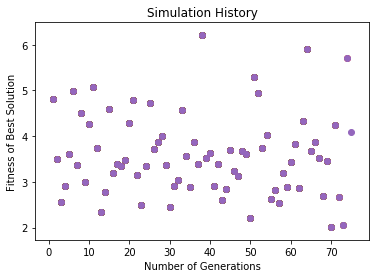

KeyboardInterrupt: 

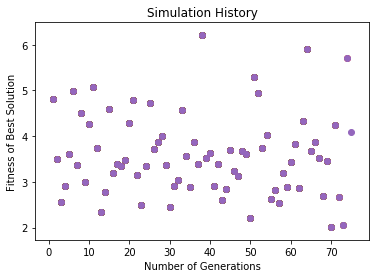

In [220]:
ion_channel_fit(patch_clamp_data)

In [224]:
all_orgs.sort(key=operator.itemgetter(1))

In [227]:
running_tally

[4.8229912071156225,
 3.4951548710328697,
 2.5623360590460105,
 2.898097725074769,
 3.6046755978141367,
 4.990286181822435,
 3.3722922539134017,
 4.498469139708022,
 2.9959472140665113,
 4.261336664793533,
 5.06741163432919,
 3.731758067429098,
 2.3414145349473463,
 2.7671605301551714,
 4.602305625534897,
 3.1860134245732925,
 3.39200102745679,
 3.349457892114768,
 3.485466847452426,
 4.2921130223426385,
 4.781858734541925,
 3.1472881442136287,
 2.489403362670007,
 3.342680803772706,
 4.725797327687613,
 3.7104297660897236,
 3.86970823223431,
 4.0115615477779185,
 3.371180885251043,
 2.4441691222579047,
 2.918837899874331,
 3.0399034725324974,
 4.574244252910674,
 3.571203451668699,
 2.894167823450506,
 3.8623125850829543,
 3.385052333871435,
 6.207226584485604,
 3.5305748232078757,
 3.6367895217393222,
 2.9042086459853924,
 3.4003027113791595,
 2.59635308897488,
 2.8471952804434992,
 3.6914389000301955,
 3.2471306484254794,
 3.135677466305272,
 3.675248224557606,
 3.6098930716510647,
